In [73]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import warnings
from datetime import timedelta

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

import optuna
from lightgbm import LGBMRegressor

In [3]:
warnings.simplefilter('ignore', category=FutureWarning)

## EDA

In [5]:
df = pd.read_csv('../data/train_dataset.csv')

In [6]:
df.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          37224 non-null  object 
 1   time          37224 non-null  int64  
 2   target        37224 non-null  float64
 3   temp          37224 non-null  float64
 4   temp_pred     37136 non-null  float64
 5   weather_pred  37136 non-null  object 
 6   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.0+ MB


In [8]:
df.duplicated().sum()

0

- предоставлен датасет, включающий 37224 строки и 7 столбцов с данными, три столбца имеют численный тип остальные строковый. Дубликаты в записях отсутствуют, но присутствут пропуски в столбцах с предсказаниями по погоде и температуре. Пропуски заполню предыдущими значениями. Также сразу переведу столбец с датой во временной тип.

In [9]:
df.temp_pred = df.temp_pred.ffill()
df.weather_pred = df.weather_pred.ffill()
df.weather_fact = df.weather_fact.ffill()
df.date = pd.to_datetime(df.date)

***Разведочный анализ данных:***

- в данном разделе проведем:
  - анализ распределения целевой переменной, численных и категориальных данных
  - анализ временных рядов

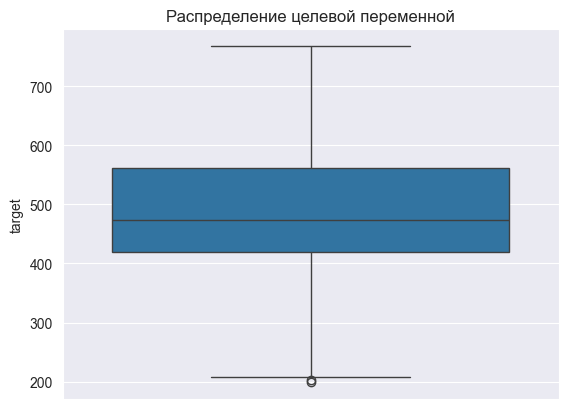

In [10]:
sns.boxplot(data=df.target).set_title('Распределение целевой переменной');

In [11]:
print(f'Целевая переменная распределена со скосом в правую сторону, что подтверждает превышение среднего значения\
 {round(df.target.mean())} над медианным {round(df.target.median())}')

Целевая переменная распределена со скосом в правую сторону, что подтверждает превышение среднего значения 484 над медианным 473


- теперь проверим данные на гетероскедастичность, подгоним простую модель линейной регрессии, используя таргет в качестве зависимой переменной, предиктором выступит фактическая температура. Далее проведу тест Бреуша-Пагана, для проверки данных на гетероскедастичность:
  - Нулевая гипотеза - присутствует гомоскедастичность
  - Альтернативная гипотеза - отсутствует гомоскедастичность(присутствует гетероскедастичность)

In [12]:
res = smf.ols('target ~ temp', data=df).fit()
names = ['Lagrange multiplier statictic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(names, test)

[('Lagrange multiplier statictic', 310.8396502178538),
 ('p-value', 1.4332215497403768e-69),
 ('f-value', 313.4403381009121),
 ('f p-value', 7.526188486566703e-70)]

- p-value ниже 0.05, мы можем отвергнуть нулевую гипотезу и предположить, что в данных присутствует гетероскедастичность, так как это будет негативно сказываться на работе регрессионных моделей. Необходимо ее исправлять(преобразовывать зависимую переменную, использовать взвешенную регрессию)

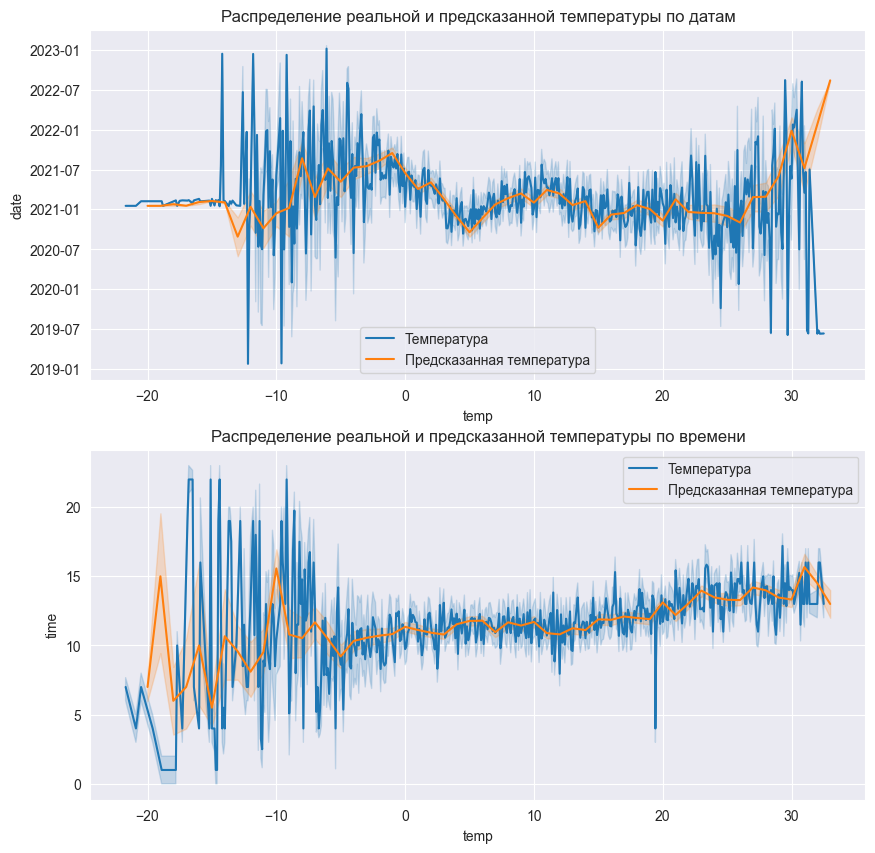

In [13]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
sns.lineplot(x=df.temp, y=df.date, ax=axs[0], label='Температура')
sns.lineplot(x=df.temp_pred, y=df.date, ax=axs[0], legend=True, label='Предсказанная температура')\
    .set_title('Распределение реальной и предсказанной температуры по датам')
sns.lineplot(x=df.temp, y=df.time, ax=axs[1], label='Температура')
sns.lineplot(x=df.temp_pred, y=df.time, ax=axs[1], legend=True, label='Предсказанная температура')\
    .set_title('Распределение реальной и предсказанной температуры по времени')
plt.show()

- по визуализации видно, что предсказанная температура сглаживает реальные показатели, в данной ситуации необходимо либо использовать только предсказанную температуру в качестве признака,убрав реальную с ее "выбросами", либо создать модель регрессии, которая будет учитывать и эти "выбросы" тоже.

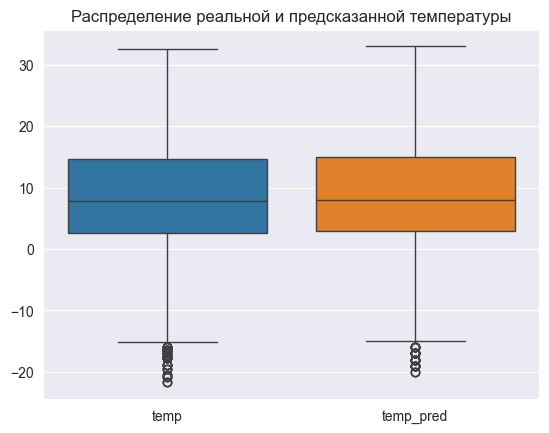

In [14]:
sns.boxplot(data = [df.temp, df.temp_pred])\
    .set_title('Распределение реальной и предсказанной температуры')
plt.show()

In [15]:
print(f'{round((df[df.temp<-17.0].shape[0]*100)/df.shape[0], 2)}% от всего датасета реальная температура '\
 'ниже 17 градусов')
print(f'{round((df[df.temp_pred<-17.0].shape[0]*100)/df.shape[0], 2)}% от всего датасета предсказанная '\
     'температура ниже 17 градусов')

0.09% от всего датасета реальная температура ниже 17 градусов
0.06% от всего датасета предсказанная температура ниже 17 градусов


In [16]:
df.temp.sort_values().head(10).to_frame()

,temp
17934,-21.7
17936,-21.7
17935,-21.7
17932,-20.9
17933,-20.9
17931,-20.9
18440,-20.5
18439,-20.5
18438,-20.5
18436,-19.6


- низкие температуры встречаются довольно редко в реальных данных, еще реже в предсказанных данных

In [17]:
df.weather_fact.value_counts().to_frame()

,count
weather_fact,
ясно,6264
пасмурно,4653
облачно,3323
"пасм, дождь",1753
п/обл,1696
...,...
ледяной дождь,1
"обл.,слаб.дождь",1
снежок небольшой,1


In [18]:
df.weather_pred.value_counts().to_frame()

,count
weather_pred,
ясно,3787
п/обл,3033
пасмурно,1612
облачно,1573
пер.обл.,1273
...,...
малообл.,1
?,1
возм.дождь 52%,1


- здесь мы также видим не совсем точное предсказанние, возможно в дальнейшем стоит рассмотреть целесообразность нахождения данного признака в итоговом наборе, по крайней мере в таком виде

- теперь  приступим к анализу временных рядов:
  - сделаем общий анализ с определением наличия тренда в разрезе годового потребления:

In [19]:
time_analys = df[['date', 'target']]
time_analys.index=time_analys.date
time_analys.drop('date', axis=1, inplace=True)
time_analys = time_analys.target
time_analys.index.is_monotonic_increasing

C:\Users\user\AppData\Local\Temp\ipykernel_1016\1944868016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_analys.drop('date', axis=1, inplace=True)


True

In [20]:
time_analys_for_year = time_analys.resample('1D').sum()
decomposed = seasonal_decompose(time_analys_for_year)

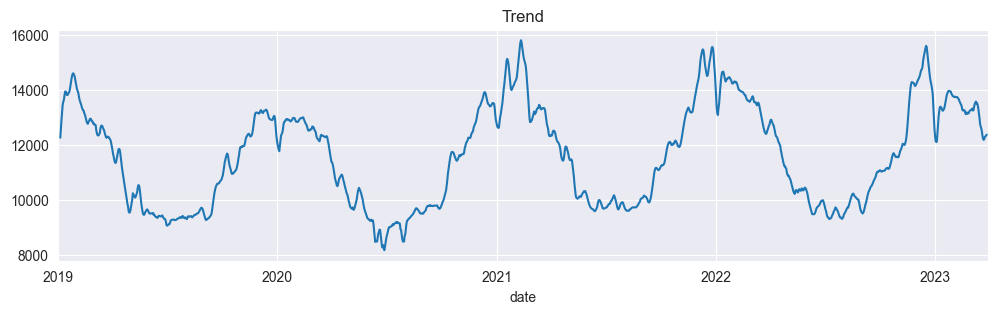

In [21]:
plt.figure(figsize=(12,3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

- общий график тренда показывает возрастание потребления электроэнергии, начиная с 2021 года, соотвественно максимумы соотвествуют холодному сезону, минимумы - летнему

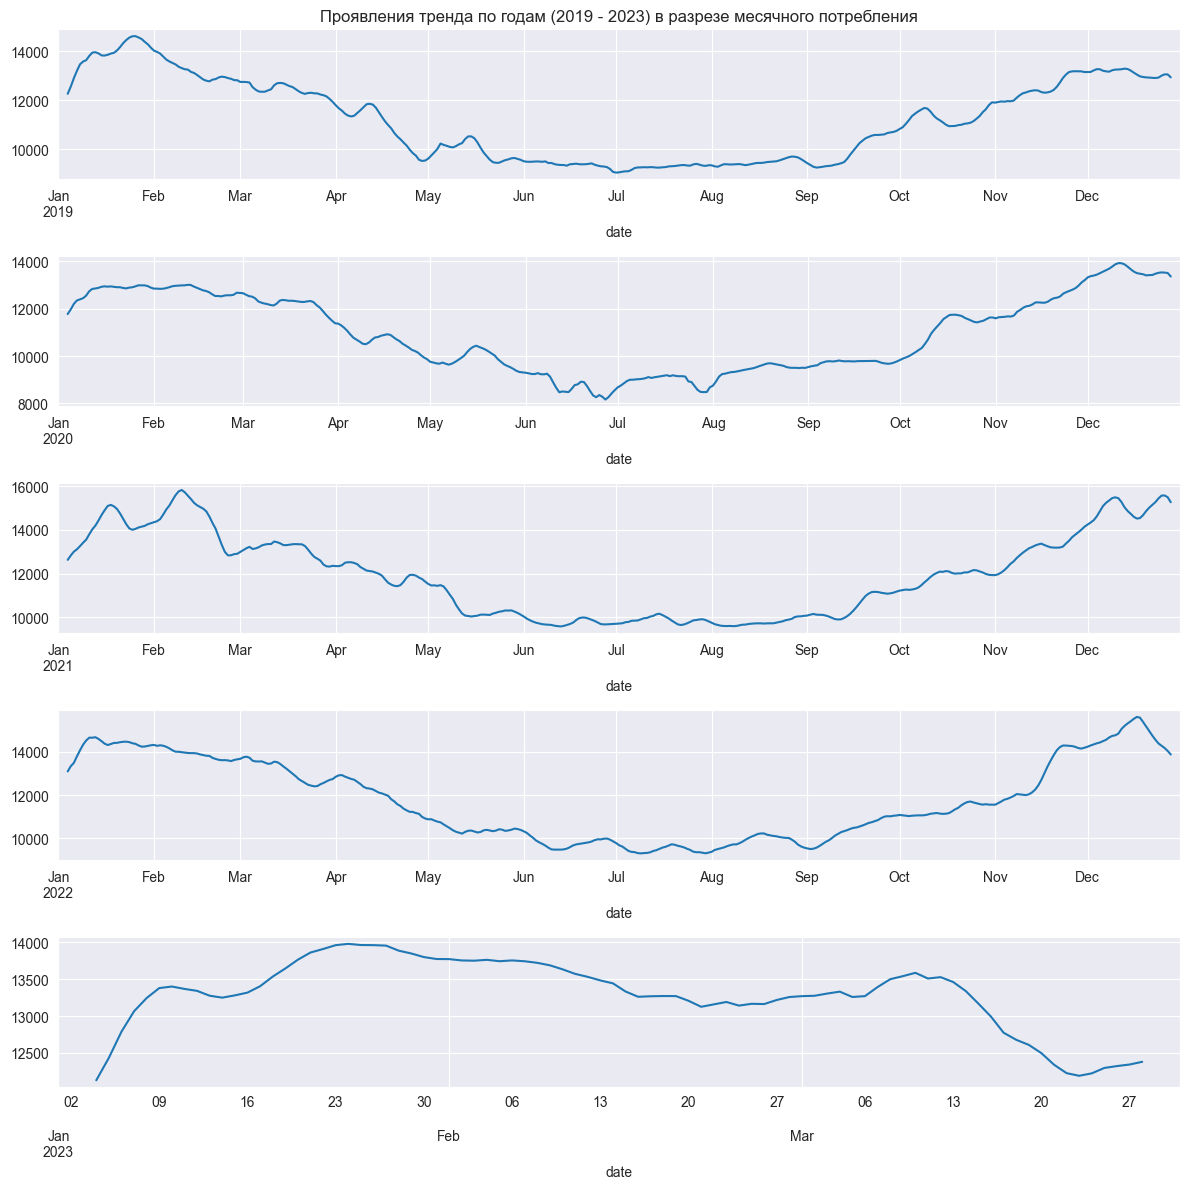

In [22]:
plt.figure(figsize=(12,12))
plt.subplot(511)
seasonal_decompose(time_analys_for_year['2019-01-01':'2019-12-31']).trend.plot(ax=plt.gca())
plt.title('Проявления тренда по годам (2019 - 2023) в разрезе месячного потребления')
plt.subplot(512)
seasonal_decompose(time_analys_for_year['2020-01-01':'2020-12-31']).trend.plot(ax=plt.gca())
plt.subplot(513)
seasonal_decompose(time_analys_for_year['2021-01-01':'2021-12-31']).trend.plot(ax=plt.gca())
plt.subplot(514)
seasonal_decompose(time_analys_for_year['2022-01-01':'2022-12-31']).trend.plot(ax=plt.gca())
plt.subplot(515)
seasonal_decompose(time_analys_for_year['2023-01-01':'2023-03-31']).trend.plot(ax=plt.gca())
plt.tight_layout();

- на погодовых графиках прослеживается увеличениие потребления в период холодного времени года, но есть и интересные моменты такие как, например снижение потребления в марте и сентябре 2022 года, нужно проанализировать эти моменты возможно они помогут далее при создании дополнительных признаков.

In [23]:
print(f'Снижение потребления в данный период нельзя связать, например с увеличением средней температуры\
за аналогичный  в предыдущем году, температура наоборот снизилась. Медианное значение за сентябрь 2022:\
 {df[(df.date.dt.month==9)&(df.date.dt.year==2022)].temp.median()} за сентябрь 2019:\
    {df[(df.date.dt.month==9)&(df.date.dt.year==2019)].temp.median()}')

Снижение потребления в данный период нельзя связать, например с увеличением средней температурыза аналогичный  в предыдущем году, температура наоборот снизилась. Медианное значение за сентябрь 2022: 11.1 за сентябрь 2019:    14.0


- но это возможно объяснить следующей информацией: "Выработка электроэнергии электростанциями энергосистемы Калининградской области в сентябре 2022 года составила 339,8 млн кВт⋅ч, что на 9,9 % меньше, чем в сентябре 2021 года. Уменьшение показателя связано со снижением экспортных перетоков."

- проведу тест Дики-Фуллера для проверки стационарности временного ряда, также построю графики автокорреляции

In [24]:
def tsplot(y, lags=None, figsize=(12, 4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0), colspan=2)

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)

        print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.084301


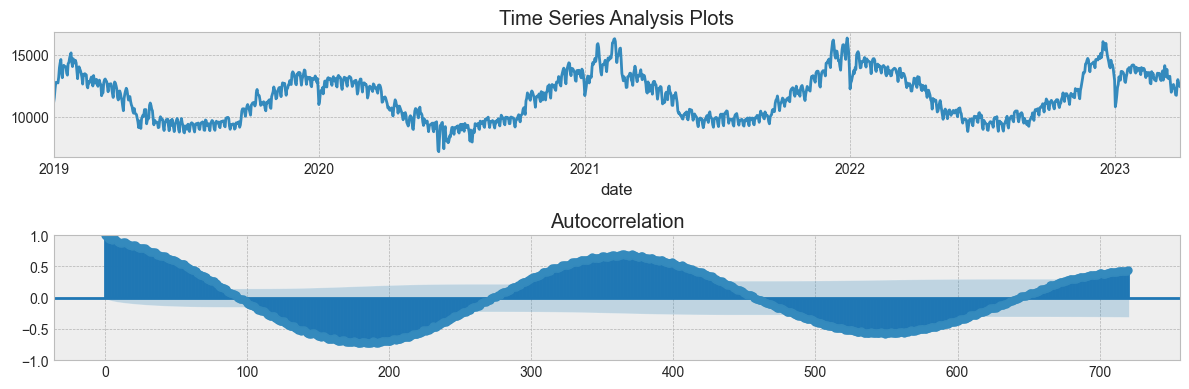

In [25]:
tsplot(time_analys_for_year, lags=720)

- после проведения теста Дики-Фулера мы не можем отвергнуть нулевую гипотезу, и продолжаем считать, что временной ряд в разрезе одного дня является нестационарным (имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени). Один из используемых методов прогнозирования нестационарных временных рядов, авторегрессионное интегрированное скользящее среднее ARIMA, позволяет с хорошим качеством прогнозировать временные ряды с трендом, а также при небольшой модификации и ряды с сезонной компонентой
- по графику автокорреляции мы видим наличие сезонности периода около 180 дней

- теперь проведем ресемплирование по часу:

In [26]:
time_analys_for_day = time_analys.resample('1h').sum()
decomposed = seasonal_decompose(time_analys_for_day)

Критерий Дики-Фуллера: p=0.000233


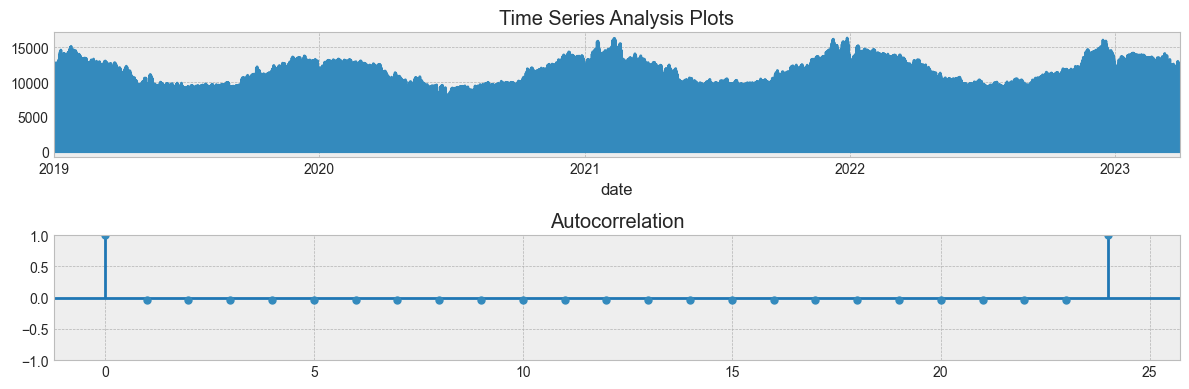

In [27]:
tsplot(time_analys_for_day, lags=24)

- касательно распределения целевой в разрезе суток мы видим(и получаем подтверждение по критерию оценки Дики-Фуллера), что данный временной ряд относится к классу ТS(ряды, становящиеся стационарными после вычитания из них детерминированного тренда)
- также график автокорреляции подтверждает гипотезу о том, что колебания целевой переменной укладываюся в период равный 24 часам.

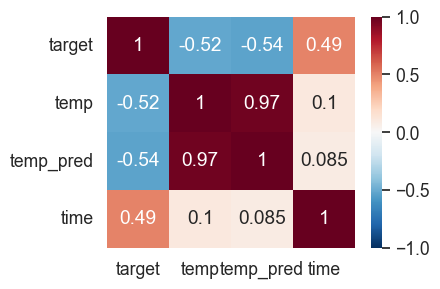

In [28]:
sns.set(font_scale=1.15)
plt.figure(figsize=(4,3))
sns.heatmap(
df[['target', 'temp', 'temp_pred', 'time']].corr(),        
    cmap='RdBu_r', 
    annot=True,
    vmin=-1, vmax=1);

***Выводы:***
- целевая переменная(target) рапспределена с небольшим скосом в правую сторону(есть превышение среднего над медианным значением). В данных присутствует гетероскедастичность, так как это будет негативно сказываться на работе регрессионных моделей. Необходимо ее исправлять(преобразовывать зависимую переменную, использовать взвешенную регрессию)
- по визуализации видно, что предсказанная температура сглаживает реальные показатели, в данной ситуации необходимо либо использовать только предсказанную температуру в качестве признака,убрав реальную с ее "выбросами", либо создать модель регрессии, которая будет учитывать и эти "выбросы" тоже.
- необходимо произвести предобработку строкового описания фактического состоянии и прогноза погоды, чтобы появилась возможность сопоставления этих данных
- общий график тренда показывает возрастание потребления электроэнергии, начиная с 2021 года, соотвественно максимумы соотвествуют холодному сезону, минимумы - летнему
- после проведения теста Дики-Фулера мы не можем отвергнуть нулевую гипотезу, и продолжаем считать, что временной ряд в разрезе одного дня является нестационарным (имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени). Один из используемых методов прогнозирования нестационарных временных рядов, авторегрессионное интегрированное скользящее среднее ARIMA, позволяет с хорошим качеством прогнозировать временные ряды с трендом, а также при небольшой модификации и ряды с сезонной компонентой. По графику автокорреляции мы видим наличие сезонности периода около 180 дней
- а вот касательно распределения целевой в разрезе суток мы видим(и получаем подтверждение по критерию оценки Дики-Фуллера), что данный временной ряд относится к классу ТS(ряды, становящиеся стационарными после вычитания из них детерминированного тренда), также график автокорреляции подтверждает гипотезу о том, что колебания целевой переменной укладываюся в период равный 24 часам
- тепловая карта показывает наличие устойчивой положительной корреляции между таргетом и временем и отрицательной между таргетом и фактической и предсказанной температурой.

## Preparing

In [29]:
CV = TimeSeriesSplit(n_splits=5)

In [30]:
scaler = MinMaxScaler()
target_encoder = TargetEncoder()

In [31]:
def features_extractor(dataset, target_encoder):
    features = pd.DataFrame()
    res_dataset = dataset.resample('1D')

    # Вчерашняя температура
    features['temp_pred'] = res_dataset.agg({'temp_pred': 'mean'})
    features['yst_temp_min'] = res_dataset.agg({'temp': 'min'}).shift(1)
    features['yst_temp_med'] = res_dataset.agg({'temp': 'median'}).shift(1)
    for i in range(3):
        features[f'yst_temp_mean{i+1}'] = res_dataset.agg({'temp': 'mean'}).shift(i+1)
    features['yst_temp_max'] = res_dataset.agg({'temp': 'max'}).shift(1)
    features['yst_temp_last'] = dataset.query('time==23')['temp'].shift(1)
    # Вчерашний таргет
    features['yst_target_min'] = res_dataset.agg({'target': 'min'}).shift(1)
    features['yst_target_med'] = res_dataset.agg({'target': 'median'}).shift(1)
    features['yst_target_mean'] = res_dataset.agg({'target': 'mean'}).shift(1)
    features['yst_target_max'] = res_dataset.agg({'target': 'max'}).shift(1)
    features['yst_target_last'] = dataset.query('time==23')['target'].shift(1)

    # Погода энкодед
    features[['weather_pred', 'yst_weather_fact_1']] = (
        target_encoder.transform(dataset[['weather_pred', 'weather_fact']]).resample('D').mean()
    )
    features['yst_weather_fact_1'] = features['yst_weather_fact_1'].shift(1)
    for i in range(1, 2):
        features[f'yst_weather_fact_{i+1}'] = features['yst_weather_fact_1'].shift(i+1)


    # Лаг
    for i in range(31):
        features[f'target_lag_{i+1}'] = res_dataset.agg({'target': 'sum'}).shift(i+1)


    # Дни
    features['week_day'] = features.index.dayofweek
    features['year'] = features.index.year
    features['month'] = features.index.month
    features['day'] = features.index.day
    #features['quarter'] = (features.index.month - 1) // 3 + 1

    # Выходные праздники
    #features['is_weekend'] = [1 if day == 6 or day == 0 else 0 for day in features.week_day]
    holidays_list = []
    for i in holidays.RUS(years=[2019, 2020, 2021, 2022, 2023]).items():
        holidays_list.append(str(i[0]))
    holidays_list = holidays_list + ['2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']
    features['is_holiday'] = [1 if str(val).split()[0] in holidays_list else 0 for val in features.index]

    features = features.dropna()
    return features

In [32]:
def target_creator(dataset, features_idx):
    target = dataset.resample('D').sum()['target']
    target = target[features_idx]
    return target

## TRAIN

In [34]:
df_train = pd.read_csv('../data/train_dataset.csv', index_col='date', parse_dates=True)

In [35]:
df_train

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31,19,552.960,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка"


In [36]:
target_encoder.fit(df_train[['weather_pred', 'weather_fact']], df_train['target'])

TargetEncoder(cols=['weather_pred', 'weather_fact'])

In [37]:
features_train = features_extractor(df_train, target_encoder)
features_train

,temp_pred,yst_temp_min,yst_temp_med,yst_temp_mean1,yst_temp_mean2,yst_temp_mean3,yst_temp_max,yst_temp_last,yst_target_min,yst_target_med,...,target_lag_27,target_lag_28,target_lag_29,target_lag_30,target_lag_31,week_day,year,month,day,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2019-02-01,-1.625,-5.4,-1.40,-2.2125,-3.2250,0.0750,-0.3,-1.1,471.236,653.1465,...,12735.145,12763.044,12235.564,11547.210,11126.866,4,2019,2,1,0
2019-02-02,2.625,-1.5,-0.55,-0.5875,-2.2125,-3.2250,0.1,0.1,478.837,634.4765,...,12744.419,12735.145,12763.044,12235.564,11547.210,5,2019,2,2,0
2019-02-03,2.750,1.0,2.00,2.1375,-0.5875,-2.2125,3.6,3.6,464.861,602.0425,...,12719.935,12744.419,12735.145,12763.044,12235.564,6,2019,2,3,0
2019-02-04,0.750,0.2,2.20,2.4125,2.1375,-0.5875,5.1,0.2,442.190,576.8785,...,13185.565,12719.935,12744.419,12735.145,12763.044,0,2019,2,4,0
2019-02-05,-1.875,-2.3,0.10,-0.0625,2.4125,2.1375,0.8,-2.3,447.993,619.5260,...,13949.530,13185.565,12719.935,12744.419,12735.145,1,2019,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,1.250,3.1,6.05,5.7500,7.8500,9.3500,7.8,3.1,393.980,519.9450,...,13507.624,13282.625,12879.512,12932.503,12969.070,0,2023,3,27,0
2023-03-28,-0.250,-2.4,2.45,1.4375,5.7500,7.8500,3.9,-2.4,401.041,563.5375,...,13451.016,13507.624,13282.625,12879.512,12932.503,1,2023,3,28,0
2023-03-29,1.500,-3.9,-1.10,-1.3000,1.4375,5.7500,0.9,-1.0,429.317,576.4975,...,13501.989,13451.016,13507.624,13282.625,12879.512,2,2023,3,29,0


In [38]:
target_train = target_creator(df_train, features_train.index)
target_train

date
2019-02-01    14339.162
2019-02-02    13685.459
2019-02-03    13062.013
2019-02-04    13826.987
2019-02-05    14017.026
                ...    
2023-03-27    12513.596
2023-03-28    12988.331
2023-03-29    12771.077
2023-03-30    12478.985
2023-03-31    12414.945
Freq: D, Name: target, Length: 1520, dtype: float64

In [39]:
features_train.shape, target_train.shape

((1520, 52), (1520,))

### Linear Regression

In [40]:
linear_pipeline = make_pipeline(scaler, LinearRegression())
linear_pipeline.fit(features_train, target_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [41]:
lin_cv_mae = -np.mean(cross_val_score(
    linear_pipeline,
    features_train,
    target_train,
    scoring='neg_mean_absolute_error',
    cv=CV
))

In [42]:
lin_mae = mean_absolute_error(target_train, linear_pipeline.predict(features_train))

### LightGBM Regressor

In [43]:
def objective(trial):
    # Объявляем гиперпараметры для оптимизации
    params = {
        'objective': trial.suggest_categorical('objective', ['regression', 'regression_l1']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
        #'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 1, 7, 2),
        'random_state': 42,
        'verbosity': -1
    }

    # Объявляем модель
    model = LGBMRegressor(**params)
    pipeline = make_pipeline(scaler, model)

    # Вычисляем качество
    result = cross_val_score(
        pipeline,
        features_train,
        target_train,
        scoring='neg_mean_absolute_error',
        cv=CV).mean() * -1

    return result

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=300, n_jobs=-1)

In [45]:
lgbm_model = LGBMRegressor(**study.best_params, random_state=42, verbosity=-1, n_jobs=-1)
lgbm_pipeline = make_pipeline(scaler, lgbm_model)
lgbm_pipeline.fit(features_train, target_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.6416788888288552,
                               feature_fraction=0.323613475401181,
                               lambda_l1=0.020881989544487604,
                               lambda_l2=0.2832227007854776,
                               learning_rate=0.04327996688948783, max_depth=3,
                               n_estimators=505, n_jobs=-1, num_leaves=47,
                               objective='regression', random_state=42,
                               verbosity=-1))])

In [46]:
lgbm_cv_mae = -np.mean(cross_val_score(
    lgbm_pipeline,
    features_train,
    target_train,
    scoring='neg_mean_absolute_error',
    cv=CV
))

In [47]:
lgbm_mae = mean_absolute_error(target_train, lgbm_pipeline.predict(features_train))

### Results

In [48]:
print(f'Linear MAE: {lin_mae} \n'
      f'Linear CV MAE: {lin_cv_mae} \n'
      f'LGBM MAE: {lgbm_mae} \n'
      f'LGBM CV MAE: {lgbm_cv_mae}')

Linear MAE: 143.91023028495906 
Linear CV MAE: 174.19576745669312 
LGBM MAE: 89.54338648901148 
LGBM CV MAE: 212.30394378912484


## TEST

In [51]:
df_test = pd.read_csv('../data/test_dataset.csv', index_col='date', parse_dates=True)
df_test

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


In [52]:
get_idx = [df_test.index[0] - timedelta(days=i) for i in range(1, 32)]

In [53]:
df_test = pd.concat([df_test, df_train.loc[get_idx]], axis=0)
df_test = df_test.sort_values(by=['date', 'time'])
df_test

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-03-01,0,512.865,2.5,2.0,пасм,пасмурно
2023-03-01,1,478.071,2.5,2.0,пасм,пасмурно
2023-03-01,2,456.643,2.5,2.0,пасм,пасмурно
2023-03-01,3,448.305,1.5,1.0,пасм,"пасм, ветерок"
2023-03-01,4,442.351,1.5,1.0,пасм,"пасм, ветерок"
...,...,...,...,...,...,...
2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


In [54]:
features_test = features_extractor(df_test, target_encoder)
features_test

,temp_pred,yst_temp_min,yst_temp_med,yst_temp_mean1,yst_temp_mean2,yst_temp_mean3,yst_temp_max,yst_temp_last,yst_target_min,yst_target_med,...,target_lag_27,target_lag_28,target_lag_29,target_lag_30,target_lag_31,week_day,year,month,day,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2023-04-01,3.750,6.3,7.90,8.8125,7.4375,2.3750,11.8,6.3,411.703,550.1905,...,12915.729,13014.557,13251.108,13501.989,13451.016,5,2023,4,1,0
2023-04-02,2.500,2.3,4.90,4.7375,8.8125,7.4375,6.5,2.3,405.742,543.5415,...,13492.636,12915.729,13014.557,13251.108,13501.989,6,2023,4,2,0
2023-04-03,1.125,2.0,3.00,3.8625,4.7375,8.8125,7.4,2.0,413.094,529.9045,...,13689.023,13492.636,12915.729,13014.557,13251.108,0,2023,4,3,0
2023-04-04,0.375,-1.2,0.80,1.2750,3.8625,4.7375,4.2,-1.2,415.646,566.2585,...,12945.076,13689.023,13492.636,12915.729,13014.557,1,2023,4,4,0
2023-04-05,1.500,-3.1,-0.05,0.0375,1.2750,3.8625,2.8,-0.2,434.327,580.1175,...,13581.978,12945.076,13689.023,13492.636,12915.729,2,2023,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27,17.125,12.7,16.25,16.1250,18.3750,19.2750,19.7,13.6,292.488,438.1410,...,9735.191,9705.126,9571.088,9660.043,9713.666,3,2023,7,27,0
2023-07-28,15.625,12.0,16.90,16.5875,16.1250,18.3750,20.9,12.8,291.799,438.7200,...,9175.136,9735.191,9705.126,9571.088,9660.043,4,2023,7,28,0
2023-07-29,19.500,11.0,15.90,15.6750,16.5875,16.1250,20.5,14.7,290.541,445.9135,...,8998.129,9175.136,9735.191,9705.126,9571.088,5,2023,7,29,0


In [55]:
target_test = target_creator(df_test, features_test.index)
target_test

date
2023-04-01    12145.176
2023-04-02    12026.069
2023-04-03    12633.976
2023-04-04    13042.841
2023-04-05    13074.646
                ...    
2023-07-27     9676.911
2023-07-28     9754.812
2023-07-29     9525.396
2023-07-30     9296.344
2023-07-31     9732.440
Freq: D, Name: target, Length: 122, dtype: float64

In [56]:
features_test.shape, target_test.shape

((122, 52), (122,))

In [57]:
lin_mae = mean_absolute_error(target_test, linear_pipeline.predict(features_test))
lgbm_mae = mean_absolute_error(target_test, lgbm_pipeline.predict(features_test))

In [58]:
print(f'Linear MAE: {lin_mae} \n'
      f'LGBM MAE: {lgbm_mae} \n')

Linear MAE: 152.49870120401624 
LGBM MAE: 114.25987752982766 


## FULL

In [59]:
CV = TimeSeriesSplit(n_splits=27)

In [61]:
df_full = pd.concat([
    pd.read_csv('../data/train_dataset.csv', index_col='date', parse_dates=True),
    pd.read_csv('../data/test_dataset.csv', index_col='date', parse_dates=True)
], axis=0)

In [63]:
df_full.to_csv('../data/full_dataset.csv')

In [64]:
target_encoder.fit(df_full[['weather_pred', 'weather_fact']], df_full['target'])

TargetEncoder(cols=['weather_pred', 'weather_fact'])

In [65]:
features_full = features_extractor(df_full, target_encoder)
features_full

,temp_pred,yst_temp_min,yst_temp_med,yst_temp_mean1,yst_temp_mean2,yst_temp_mean3,yst_temp_max,yst_temp_last,yst_target_min,yst_target_med,...,target_lag_27,target_lag_28,target_lag_29,target_lag_30,target_lag_31,week_day,year,month,day,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2019-02-01,-1.625,-5.4,-1.40,-2.2125,-3.2250,0.0750,-0.3,-1.1,471.236,653.1465,...,12735.145,12763.044,12235.564,11547.210,11126.866,4,2019,2,1,0
2019-02-02,2.625,-1.5,-0.55,-0.5875,-2.2125,-3.2250,0.1,0.1,478.837,634.4765,...,12744.419,12735.145,12763.044,12235.564,11547.210,5,2019,2,2,0
2019-02-03,2.750,1.0,2.00,2.1375,-0.5875,-2.2125,3.6,3.6,464.861,602.0425,...,12719.935,12744.419,12735.145,12763.044,12235.564,6,2019,2,3,0
2019-02-04,0.750,0.2,2.20,2.4125,2.1375,-0.5875,5.1,0.2,442.190,576.8785,...,13185.565,12719.935,12744.419,12735.145,12763.044,0,2019,2,4,0
2019-02-05,-1.875,-2.3,0.10,-0.0625,2.4125,2.1375,0.8,-2.3,447.993,619.5260,...,13949.530,13185.565,12719.935,12744.419,12735.145,1,2019,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27,17.125,12.7,16.25,16.1250,18.3750,19.2750,19.7,13.6,292.488,438.1410,...,9735.191,9705.126,9571.088,9660.043,9713.666,3,2023,7,27,0
2023-07-28,15.625,12.0,16.90,16.5875,16.1250,18.3750,20.9,12.8,291.799,438.7200,...,9175.136,9735.191,9705.126,9571.088,9660.043,4,2023,7,28,0
2023-07-29,19.500,11.0,15.90,15.6750,16.5875,16.1250,20.5,14.7,290.541,445.9135,...,8998.129,9175.136,9735.191,9705.126,9571.088,5,2023,7,29,0


In [66]:
target_full = target_creator(df_full, features_full.index)
target_full

date
2019-02-01    14339.162
2019-02-02    13685.459
2019-02-03    13062.013
2019-02-04    13826.987
2019-02-05    14017.026
                ...    
2023-07-27     9676.911
2023-07-28     9754.812
2023-07-29     9525.396
2023-07-30     9296.344
2023-07-31     9732.440
Freq: D, Name: target, Length: 1642, dtype: float64

In [67]:
features_full.shape, target_full.shape

((1642, 52), (1642,))

In [68]:
linear_pipeline.fit(features_full, target_full)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [69]:
def objective(trial):
    # Объявляем гиперпараметры для оптимизации
    params = {
        'objective': trial.suggest_categorical('objective', ['regression', 'regression_l1']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
        #'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 1, 7, 2),
        'random_state': 42,
        'verbosity': -1
    }

    # Объявляем модель
    model = LGBMRegressor(**params)
    pipeline = make_pipeline(scaler, model)

    # Вычисляем качество
    result = cross_val_score(
        pipeline,
        features_full,
        target_full,
        scoring='neg_mean_absolute_error',
        cv=CV).mean() * -1

    return result

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200, n_jobs=-1)

In [71]:
lgbm_model = LGBMRegressor(**study.best_params, random_state=42, verbosity=-1, n_jobs=-1)
lgbm_pipeline = make_pipeline(scaler, lgbm_model)

In [72]:
lgbm_pipeline.fit(features_full, target_full)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.4791386809725547,
                               feature_fraction=0.5075210058024825,
                               lambda_l1=0.932354825406278,
                               lambda_l2=0.5172472915542038,
                               learning_rate=0.058926979437778006, max_depth=3,
                               n_estimators=539, n_jobs=-1, num_leaves=44,
                               objective='regression', random_state=42,
                               verbosity=-1))])

### Results

In [74]:
lin_mae = mean_absolute_error(target_full, linear_pipeline.predict(features_full))
lgbm_mae = mean_absolute_error(target_full, lgbm_pipeline.predict(features_full))
lin_cv_mae = -np.mean(cross_val_score(linear_pipeline, features_full, target_full, cv=CV, scoring='neg_mean_absolute_error'))
lgbm_cv_mae = -np.mean(cross_val_score(lgbm_pipeline, features_full, target_full, cv=CV, scoring='neg_mean_absolute_error'))

In [75]:
print(f'Linear MAE: {lin_mae} \n'
      f'Linear CV MAE: {lin_cv_mae} \n'
      f'LGBM MAE: {lgbm_mae} \n'
      f'LGBM CV MAE: {lgbm_cv_mae}')

Linear MAE: 143.66088946894772 
Linear CV MAE: 188.27007366030972 
LGBM MAE: 80.14068722570562 
LGBM CV MAE: 240.11500260564407


### Features Importance

In [76]:
# Важность фичей для линейной регрессии
importance = permutation_importance(linear_pipeline,
                                    features_full,
                                    target_full,
                                    n_repeats=50,
                                    random_state=42,
                                    scoring='neg_mean_absolute_error')
for i in importance.importances_mean.argsort()[::-1]:
    print(f'{features_test.columns[i]:<40}'
          f'{importance.importances_mean[i]:.3f}'
          f' +/- {importance.importances_std[i]:.3f}')

yst_target_med                          662.607 +/- 11.261
yst_target_max                          649.754 +/- 11.278
yst_target_last                         554.146 +/- 9.947
target_lag_1                            271.408 +/- 6.162
yst_target_mean                         271.408 +/- 6.162
target_lag_6                            241.432 +/- 5.292
yst_target_min                          200.094 +/- 4.559
target_lag_5                            131.679 +/- 3.292
yst_temp_med                            117.959 +/- 3.105
week_day                                116.111 +/- 4.180
target_lag_12                           93.237 +/- 3.218
temp_pred                               77.151 +/- 2.918
target_lag_22                           76.589 +/- 2.623
target_lag_21                           70.099 +/- 2.492
target_lag_7                            51.910 +/- 2.111
target_lag_14                           47.190 +/- 1.927
target_lag_11                           46.987 +/- 2.055
target_lag_15      

In [77]:
# Важность фичей для бустинга
importance = permutation_importance(lgbm_pipeline,
                                    features_full,
                                    target_full,
                                    n_repeats=50,
                                    random_state=42,
                                    scoring='neg_mean_absolute_error')
for i in importance.importances_mean.argsort()[::-1]:
    print(f'{features_test.columns[i]:<40}'
          f'{importance.importances_mean[i]:.3f}'
          f' +/- {importance.importances_std[i]:.3f}')

yst_target_max                          596.388 +/- 11.137
yst_target_last                         343.587 +/- 5.132
target_lag_1                            222.732 +/- 4.263
week_day                                139.687 +/- 3.248
temp_pred                               138.573 +/- 3.297
yst_target_med                          62.179 +/- 1.418
target_lag_6                            61.384 +/- 1.931
yst_target_mean                         46.534 +/- 1.301
month                                   23.498 +/- 1.263
is_holiday                              23.123 +/- 1.002
yst_temp_max                            15.328 +/- 0.887
target_lag_7                            14.521 +/- 0.789
yst_temp_last                           12.139 +/- 0.681
weather_pred                            12.106 +/- 0.631
year                                    10.136 +/- 0.722
yst_target_min                          10.113 +/- 0.662
target_lag_30                           3.989 +/- 0.360
yst_temp_min              

## STACK

In [78]:
def objective(trial):
    # Объявляем гиперпараметры для оптимизации
    params = {
        'objective': trial.suggest_categorical('objective', ['regression', 'regression_l1']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
        #'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 1, 7, 2),
        'random_state': 42,
        'verbosity': -1
    }

    # Объявляем модель
    model = StackingRegressor(
        estimators=[('lin', linear_pipeline)],
        final_estimator=make_pipeline(scaler, LGBMRegressor(**params)), passthrough=True)
    pipeline = make_pipeline(scaler, model)

    # Вычисляем качество
    result = cross_val_score(
        pipeline,
        features_full,
        target_full,
        scoring='neg_mean_absolute_error',
        cv=CV).mean() * -1

    return result

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200, n_jobs=-1)

In [80]:
stack = StackingRegressor(
    estimators=[('lin', linear_pipeline)],
    final_estimator=make_pipeline(
        scaler, LGBMRegressor(**study.best_params, random_state=42, verbosity=-1, n_jobs=-1)),
    passthrough=True)
stack_pipeline = make_pipeline(scaler, stack)

In [81]:
stack_pipeline.fit(features_full, target_full)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('stackingregressor',
                 StackingRegressor(estimators=[('lin',
                                                Pipeline(steps=[('minmaxscaler',
                                                                 MinMaxScaler()),
                                                                ('linearregression',
                                                                 LinearRegression())]))],
                                   final_estimator=Pipeline(steps=[('minmaxscaler',
                                                                    MinMaxScaler()),
                                                                   ('lgbmregressor',
                                                                    LGBMRegressor(bagging_fraction=0.3484014583475759,
                                                                                  feature_fraction=0.6109055601317331,
                                                                                  lambda_l1=0.4949467756430228,
                                                                                  lambda_l2=0.0008271367564052085,
                                                                                  learning_rate=0.03670157867921904,
                                                                                  max_depth=3,
                                                                                  n_estimators=574,
                                                                                  n_jobs=-1,
                                                                                  num_leaves=39,
                                                                                  objective='regression',
                                                                                  random_state=42,
                                                                                  verbosity=-1))]),
                                   passthrough=True))])

In [84]:
mean_absolute_error(target_full, stack_pipeline.predict(features_full))

92.43470882227565

### Dump

In [86]:
joblib.dump(target_encoder, '../files/target_encoder_1d')
joblib.dump(linear_pipeline, '../files/linear_pipeline_1d')
joblib.dump(lgbm_pipeline, '../files/lgbm_pipeline_1d')
joblib.dump(stack_pipeline, '../files/stack_pipeline_1d')

['../files/stack_pipeline_1d']

### Plot results

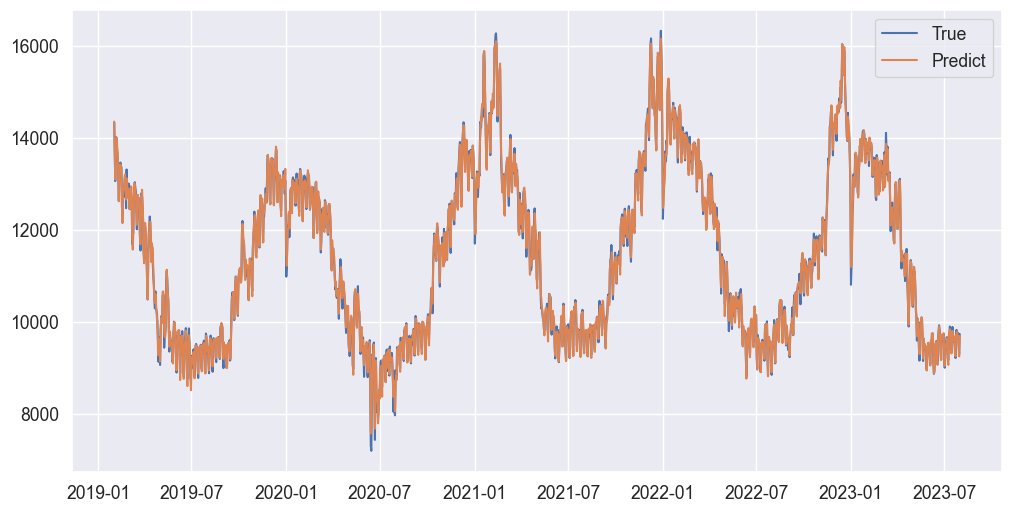

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(target_full.index, np.array(target_full), label="True")
plt.plot(target_full.index, lgbm_pipeline.predict(features_full), label='Predict')
plt.legend();